In [1]:
import pandas as pd
import numpy  as np
from time import time
#train_test_split
from sklearn.model_selection import train_test_split
#Feature scaling
from sklearn import preprocessing

from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from collections import Counter

from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
rfr = RandomForestClassifier()

In [2]:
def read_csv(dataroot):
    df=pd.read_csv(dataroot,header=0,low_memory=False)   
    pd.set_option('mode.use_inf_as_na', True) # convert inf to nan
    df['Flow Bytes/s']=df['Flow Bytes/s'].astype('float64')
    df[' Flow Packets/s']=df[' Flow Packets/s'].astype('float64')
    df['Flow Bytes/s'].fillna(df['Flow Bytes/s'].mean(),inplace=True)
    df[' Flow Packets/s'].fillna(df[' Flow Packets/s'].mean(),inplace=True)
    return df

def split_valid_from_train(train_dataset, valid_size):
    # Method 1
    train_dataset, valid_dataset, _, _ = train_test_split(train_dataset, train_dataset[' Label'], test_size=valid_size, random_state=None)
    # pandas中先重置index再打乱train. 否则只会调整各个行的顺序，而不会改变pandas的index
    # 重置
    train_dataset = train_dataset.reset_index(drop=True)
    # 打乱
    indexMask = np.arange(len(train_dataset))
    for i in range(10):
        np.random.shuffle(indexMask)
    train_dataset = train_dataset.iloc[indexMask]

    return train_dataset, valid_dataset

def shuffle(dataset):  
    # 打乱
    indexMask = np.arange(len(dataset))
    for i in range(10):
        np.random.shuffle(indexMask)
    dataset = dataset.iloc[indexMask]
    dataset = dataset.reset_index(drop=True)

    return dataset 

def labels_separate(dataset):
    y_ = dataset[' Label']
    temp = dataset
    temp.drop([' Label'], axis=1, inplace=True)
    x_ = temp.values
    return x_, y_

def labels_map(label):
    if(type(label) == int):      #已是数字，无需处理
        return label
    if label == 'BENIGN':
        return 0
    if label == 'DoS':
        return 1
    if label == 'PortScan':
        return 2
    if label == 'DDoS':
        return 3
    if label == 'SSH-Patator':
        return 4
    if label == 'FTP-Patator':
        return 5
    if label == 'Web Attack':
        return 6
    if label == 'Bot':
        return 7
    return -1   #-1表示出错
def filter_labels(dataset):
    dataset[' Label'] = dataset[' Label'].apply(labels_map)
    return dataset
#特征选取
def feature_selection(dataset):
    return dataset[[
        ' Destination Port', 'Bwd Packet Length Max',' Bwd Packet Length Min', ' Bwd Packet Length Std',
        ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Min', ' Fwd IAT Min', ' Bwd Packets/s', ' Min Packet Length',
        ' Max Packet Length', ' Init_Win_bytes_backward', ' act_data_pkt_fwd', ' Label'
    ]]
labelList = ["BENIGN", "DoS", "PortScan", "DDoS", "SSH-Patator", "FTP-Patator", "Web Attack", "Bot"]


#独热编码。选取distination port统计大于等于10以上的port作为新增维度
def create_columns_for_destination_port(train_dataset):
    countDictionary = Counter(train_dataset[' Destination Port'])
    columns = []
    columns.append('DestinationPort_Others')
    for key in countDictionary:
        if(countDictionary[key] >= 10):
            columns.append('DestinationPort_' + str(key))
    return columns

def one_hot_process_for_destination_port(dataset, columns):
    #重置索引
    dataset = dataset.reset_index(drop=True)
    #创建空表
    DestinationPort_revert = pd.DataFrame(data=np.zeros(shape=(dataset.shape[0],len(columns))), columns = columns)
    #填充空表
    for i,value in enumerate(dataset[' Destination Port'].values):
        name = "DestinationPort_" + str(value)
        if name in columns:
            DestinationPort_revert.loc[i, name] = 1
        else:
            DestinationPort_revert.loc[i, "DestinationPort_Others"] = 1
    #与原表连接
    dataset = pd.concat([dataset, DestinationPort_revert], axis=1)
    #删除原表的destination port列
    dataset = dataset.drop([' Destination Port'], axis=1)
    return dataset  


In [3]:
#DDoS
df_1 = read_csv("../MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
df_1 = df_1.drop(df_1[df_1[' Label'] == 'BENIGN'].index)
df_1 = df_1.sample(n=5000,random_state=1, replace=False)
df_1_train, df_1_test = split_valid_from_train(df_1, 0.2)
#PortScan
df_2 = read_csv("../MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
df_2 = df_2.drop(df_2[df_2[' Label'] == 'BENIGN'].index)
df_2 = df_2.sample(n=5000,random_state=1, replace=False)
df_2_train, df_2_test = split_valid_from_train(df_2, 0.2)
#Bot
df_3 = read_csv("../MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv")
df_3 = df_3.drop(df_3[df_3[' Label'] == 'BENIGN'].index)
df_3 = df_3.sample(n=5000,random_state=1, replace=True)
df_3_train, df_3_test = split_valid_from_train(df_3, 0.2)
#Benign
df_4 = read_csv("../MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv")
df_4 = df_4.sample(n=50000,random_state=1, replace=False)
df_4_train, df_4_test = split_valid_from_train(df_4, 0.2)
#Web attack
df_6 = read_csv("../MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")
df_6 = df_6.drop(df_6[df_6[' Label'] == 'BENIGN'].index)
df_6 = df_6.sample(n=5000,random_state=1, replace=True)
df_6[' Label'] = df_6[' Label'].apply(lambda x: 'Web Attack')
df_6_train, df_6_test = split_valid_from_train(df_6, 0.2)
#FTP-Patator and SSH-Patator
df_7 = read_csv("../MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv")
df_7 = df_7.drop(df_7[df_7[' Label'] == 'BENIGN'].index)
df_7_1 = df_7.drop(df_7[df_7[' Label'] == 'FTP-Patator'].index)
df_7_2 = df_7.drop(df_7[df_7[' Label'] == 'SSH-Patator'].index)
df_7_1 = df_7_1.sample(n=5000,random_state=1, replace=False)
df_7_2 = df_7_2.sample(n=5000,random_state=1, replace=False)
df_7_1_train, df_7_1_test = split_valid_from_train(df_7_1, 0.2)
df_7_2_train, df_7_2_test = split_valid_from_train(df_7_2, 0.2)
#DoS
df_8 = read_csv("../MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv")
df_8 = df_8.drop(df_8[df_8[' Label'] == 'BENIGN'].index)
df_8 = df_8.sample(n=5000,random_state=1, replace=False)
df_8[' Label'] = df_8[' Label'].apply(lambda x: 'DoS')
df_8_train, df_8_test = split_valid_from_train(df_8, 0.2)
#整合
df_train = df_1_train.append([df_2_train, df_3_train, df_4_train, df_6_train, df_7_1_train,df_7_2_train,df_8_train])
df_test = df_1_test.append([df_2_test, df_3_test, df_4_test, df_6_test, df_7_1_test,df_7_2_test,df_8_test])

In [4]:
print(df_train.shape)
print(df_train.loc[:,' Label'].value_counts())

(68000, 79)
BENIGN         40000
SSH-Patator     4000
PortScan        4000
Bot             4000
FTP-Patator     4000
DoS             4000
DDoS            4000
Web Attack      4000
Name:  Label, dtype: int64


In [5]:
#标签的字符转化成数字
df_train = filter_labels(df_train)
#对destination port进行独热编码
columns = create_columns_for_destination_port(df_train)
df_train = one_hot_process_for_destination_port(df_train, columns)
#分离标签
df_train_X, df_train_y = labels_separate(df_train)
#Normalization
scaler = preprocessing.MinMaxScaler()
df_train_X = scaler.fit_transform(df_train_X)

In [6]:
df_test = filter_labels(df_test)
df_test = one_hot_process_for_destination_port(df_test, columns)
df_test_X, df_test_y = labels_separate(df_test)
df_test_X = scaler.fit_transform(df_test_X)

In [7]:
print(df_train_X.shape)
print(df_train_y.shape)
#print(df_train.loc[:,' Label'].value_counts())

(68000, 104)
(68000,)


In [8]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from tensorflow.keras.layers import BatchNormalization
#超参数设置
learning_rate = 0.001
epochs = 30
batch_size = 256
activation = tf.nn.relu         #非输出层下的激活函数

In [9]:
#用于记录训练中每个batch的loss
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.train_losses_per_batch = []
        self.train_losses_per_epoch = []
        self.valid_losses_per_epoch = []
        
    def on_batch_end(self, batch, logs={}):
        self.train_losses_per_batch.append(logs.get('loss'))
        
    def on_epoch_end(self, epoch, logs={}):
        self.train_losses_per_epoch.append(logs.get('loss'))
        self.valid_losses_per_epoch.append(logs.get('val_loss')*4)   #验证集由于只有1/4的训练集大小所以损失要乘以4
#用于记录训练中每个epoch的召回率，精确度以及f1 score
class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
        return

    def on_epoch_end(self, epoch, logs={}):
        predictions = self.model.predict(df_test_X)
        val_predict = np.argmax(predictions, axis=1)     #把独热编码转化成数字
        val_targ = df_test_y
        _val_recall = recall_score(val_targ, val_predict, average='macro')
        _val_precision = precision_score(val_targ, val_predict, average='macro')
        _val_f1 = f1_score(val_targ, val_predict, average='macro')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        return       
#回调：模型跑完epoch后选取最好的epoch模型保存，选取标准为验证集损失最小的那一个
checkpoint = keras.callbacks.ModelCheckpoint(      
    "./Test8_model.h5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    period=1
)
def simple_model():
    model = keras.Sequential([
        keras.layers.Dense(df_train_X.shape[1], activation=activation, input_shape=(df_train_X.shape[1],)),
        BatchNormalization(),
        keras.layers.Dense(64, activation=activation),
        BatchNormalization(),
        keras.layers.Dense(64, activation=activation),
        BatchNormalization(),
        keras.layers.Dense(8,activation=tf.nn.softmax)
    ])
    model.compile(optimizer =tf.train.AdamOptimizer(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=['accuracy']
    )
    model.summary()
    history = LossHistory()
    metrics = Metrics()
    model.fit(
        df_train_X,df_train_y,
        validation_data=[df_test_X, df_test_y],
        batch_size=batch_size,epochs=epochs,
        callbacks=[history, metrics, checkpoint]
    )   
    return model,history,metrics
model,history,metrics = simple_model()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 104)               10920     
_________________________________________________________________
batch_normalization_v1 (Batc (None, 104)               416       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                6720      
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 64)                256       
_________________________________________________________________
dens

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


66816/68000 [============================>.] - ETA: 0s - loss: 0.1076 - acc: 0.9551
Epoch 00002: val_loss improved from 0.99625 to 0.78518, saving model to ./Test8_model.h5
68000/68000 [==============================] - 3s 43us/sample - loss: 0.1077 - acc: 0.9551 - val_loss: 0.7852 - val_acc: 0.8289
Epoch 3/30
67328/68000 [============================>.] - ETA: 0s - loss: 0.0924 - acc: 0.9596
Epoch 00003: val_loss did not improve from 0.78518
68000/68000 [==============================] - 3s 41us/sample - loss: 0.0927 - acc: 0.9595 - val_loss: 1.2216 - val_acc: 0.8204
Epoch 4/30
66560/68000 [============================>.] - ETA: 0s - loss: 0.0842 - acc: 0.9628
Epoch 00004: val_loss did not improve from 0.78518
68000/68000 [==============================] - 3s 47us/sample - loss: 0.0837 - acc: 0.9631 - val_loss: 1.3733 - val_acc: 0.7751
Epoch 5/30
67328/68000 [============================>.] - ETA: 0s - loss: 0.0740 - acc: 0.9674
Epoch 00005: val_loss did not improve from 0.78518
68000

In [10]:
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.rcParams['font.sans-serif'] = ['SimHei']

/opt/conda/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


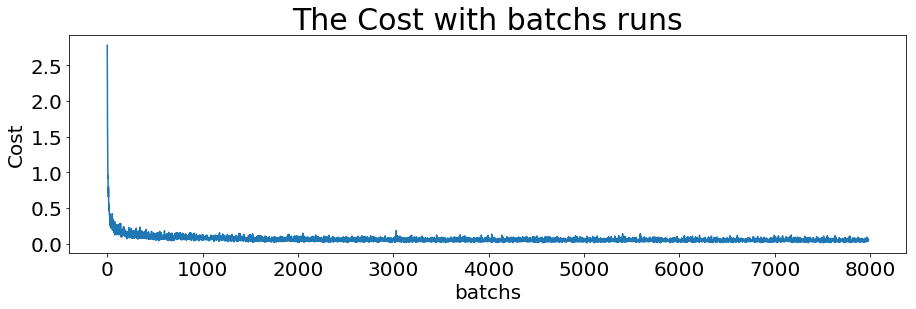

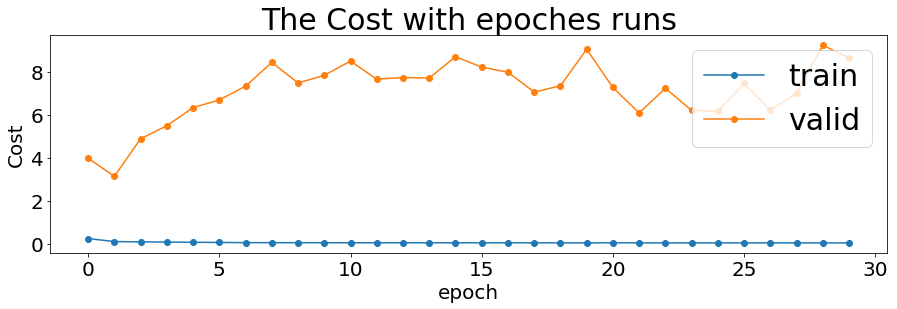

In [11]:
#绘制训练集在batch下的损失变化
plt.title('The Cost with batchs runs',fontsize=30)
plt.xlabel('batchs',fontsize=20)
plt.ylabel('Cost',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(history.train_losses_per_batch)
plt.gcf().set_size_inches(15,4)
plt.show()
#绘制训练集与验证集在epoch下的损失比较
plt.title('The Cost with epoches runs',fontsize=30)
plt.xlabel('epoch',fontsize=20)
plt.ylabel('Cost',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(history.train_losses_per_epoch, '-o', label='train')
plt.plot(history.valid_losses_per_epoch, '-o', label='valid')
plt.legend(fontsize=30,loc='upper right')
plt.gcf().set_size_inches(15,4)
plt.show()

In [12]:
#选取验证集准确率最高的模型
model = keras.models.load_model('./Test8_model.h5') 
model.compile(optimizer =tf.train.AdamOptimizer(learning_rate=learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)
#测试集的正确率
def use_evaluate_test():
    test_loss,test_acc = model.evaluate(df_test_X,df_test_y)
    print('Test accuracy:', test_acc)
    return 
use_evaluate_test()

17000/17000 [==============================] - 1s 66us/sample - loss: 0.7852 - acc: 0.8289
Test accuracy: 0.82888234


In [13]:
predictions = model.predict(df_test_X)
print(classification_report(df_test_y, np.argmax(predictions, axis=1) , target_names=labelList))

              precision    recall  f1-score   support

      BENIGN       0.81      0.98      0.89     10000
         DoS       0.62      0.72      0.67      1000
    PortScan       1.00      0.98      0.99      1000
        DDoS       0.95      0.43      0.60      1000
 SSH-Patator       0.96      1.00      0.98      1000
 FTP-Patator       0.99      0.49      0.66      1000
  Web Attack       0.15      0.03      0.04      1000
         Bot       0.99      0.61      0.75      1000

   micro avg       0.83      0.83      0.83     17000
   macro avg       0.81      0.66      0.70     17000
weighted avg       0.81      0.83      0.80     17000



In [ ]:
from sklearn.ensemble import RandomForestClassifier
score = 0
for i in range(100):
    rfc = RandomForestClassifier()
    rfc.fit(df_train_X, df_train_y)
    y_pred = rfc.predict(df_test_X)
    result = rfc.score(df_test_X, df_test_y)
    if(score < result):
        score = result
        print(score)
        print(classification_report(df_test_y, y_pred, target_names=labelList))
        
#测试集的正确率
#测试集的各个参数



/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8725294117647059
              precision    recall  f1-score   support

      BENIGN       0.82      1.00      0.90     10000
         DoS       0.99      0.96      0.97      1000
    PortScan       1.00      0.48      0.65      1000
        DDoS       1.00      0.90      0.95      1000
 SSH-Patator       1.00      1.00      1.00      1000
 FTP-Patator       1.00      1.00      1.00      1000
  Web Attack       0.98      0.11      0.19      1000
         Bot       1.00      0.40      0.57      1000

   micro avg       0.87      0.87      0.87     17000
   macro avg       0.97      0.73      0.78     17000
weighted avg       0.89      0.87      0.84     17000



/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8844705882352941
              precision    recall  f1-score   support

      BENIGN       0.85      1.00      0.92     10000
         DoS       0.88      0.94      0.91      1000
    PortScan       1.00      0.99      1.00      1000
        DDoS       1.00      0.49      0.66      1000
 SSH-Patator       1.00      0.98      0.99      1000
 FTP-Patator       1.00      1.00      1.00      1000
  Web Attack       1.00      0.11      0.19      1000
         Bot       1.00      0.52      0.69      1000

   micro avg       0.88      0.88      0.88     17000
   macro avg       0.96      0.75      0.79     17000
weighted avg       0.90      0.88      0.86     17000



/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9352941176470588
              precision    recall  f1-score   support

      BENIGN       0.90      1.00      0.95     10000
         DoS       1.00      0.93      0.96      1000
    PortScan       1.00      1.00      1.00      1000
        DDoS       1.00      0.62      0.77      1000
 SSH-Patator       0.98      1.00      0.99      1000
 FTP-Patator       1.00      1.00      1.00      1000
  Web Attack       1.00      0.78      0.88      1000
         Bot       1.00      0.60      0.75      1000

   micro avg       0.94      0.94      0.94     17000
   macro avg       0.98      0.87      0.91     17000
weighted avg       0.94      0.94      0.93     17000



/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9416470588235294
              precision    recall  f1-score   support

      BENIGN       0.91      1.00      0.95     10000
         DoS       1.00      0.96      0.98      1000
    PortScan       1.00      1.00      1.00      1000
        DDoS       1.00      0.62      0.77      1000
 SSH-Patator       1.00      0.93      0.96      1000
 FTP-Patator       1.00      1.00      1.00      1000
  Web Attack       1.00      0.77      0.87      1000
         Bot       0.99      0.74      0.85      1000

   micro avg       0.94      0.94      0.94     17000
   macro avg       0.99      0.88      0.92     17000
weighted avg       0.95      0.94      0.94     17000



/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

0.9543529411764706
              precision    recall  f1-score   support

      BENIGN       0.93      1.00      0.96     10000
         DoS       1.00      0.92      0.96      1000
    PortScan       1.00      1.00      1.00      1000
        DDoS       1.00      0.86      0.92      1000
 SSH-Patator       1.00      1.00      1.00      1000
 FTP-Patator       1.00      1.00      1.00      1000
  Web Attack       1.00      0.72      0.84      1000
         Bot       0.99      0.74      0.85      1000

   micro avg       0.95      0.95      0.95     17000
   macro avg       0.99      0.90      0.94     17000
weighted avg       0.96      0.95      0.95     17000



/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

0.9651764705882353
              precision    recall  f1-score   support

      BENIGN       0.95      1.00      0.97     10000
         DoS       0.97      0.92      0.94      1000
    PortScan       1.00      0.99      1.00      1000
        DDoS       0.99      0.97      0.98      1000
 SSH-Patator       1.00      1.00      1.00      1000
 FTP-Patator       1.00      0.97      0.98      1000
  Web Attack       1.00      0.95      0.97      1000
         Bot       1.00      0.62      0.77      1000

   micro avg       0.97      0.97      0.97     17000
   macro avg       0.99      0.93      0.95     17000
weighted avg       0.97      0.97      0.96     17000



/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de